In [1]:
import numpy as np
from astropy import constants as ca
from funcs.blackbody_model import _brightness_mod, brightness_mod_continous
from funcs.probabilities_emcee import log_loglikelihood, log_logprior_global_uniform, \
      plot_corner_emcee, plot_walker_emcee, display_median_from_chain,  log_logprobability, log_likelihood
import sys 
import matplotlib.pyplot as plt
import astropy.units as u

In [2]:
#import brightness and error for each Flare and TRAPPIST-1
flare1 = np.genfromtxt("../results/values/brightnesstot_flare1_TRAPPIST-1.txt",delimiter="," , skip_header=1)
flare2 = np.genfromtxt("../results/values/brightnesstot_flare2_TRAPPIST-1.txt",delimiter="," , skip_header=1)
trappist = np.genfromtxt("../results/values/brightness_TRAPPIST-1.txt", delimiter= ",", skip_header=1)
trappist_SED = np.genfromtxt("../data/TRAPPIST1_Semimodel_Wilson/TRAPPIST-1_model_const_res_v07.ecsv")
trappistflux_M2 = np.genfromtxt("../results/values/brightness_TRAPPIST-1_withCCDeffeciency.txt", delimiter= ",", skip_header=1)

In [60]:
#import flare brightness and spectral energy dist. in M2
wavelength_SED, flux_SED = trappist_SED[:,0]*1e-10, trappist_SED[:,1]
brightness_flares, brightnesserror_flares = np.reshape(np.concatenate((flare1[0],flare2[0])), (2,4)), \
                                            np.reshape(np.concatenate((flare1[1], flare2[1])), (2,4))
#flux/brighntess is in erg cm-2 -s

#Import M2 response, passband limits
iters = ["g", "r", "i", "z"]
limit, wavelength_M2, response_M2 = [], [], []

for i in iters: 
    #limit are the limits of the passband in wavelength 
    limit.append(np.load("../data/MuSCAT2_response/MuSCAT2_limit_{}.npy".format(str(i))))
    wavelength_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_wavelength_{}.npy".format(str(i))))
    response_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_response_{}_bandpass.npy".format(str(i))))

In [61]:
#Convert to correct unit
brightness_flares = brightness_flares* u.erg *u.s**(-1) * u.cm**(-2)
brightnesserror_flares = brightnesserror_flares * u.erg *u.s**(-1) * u.cm**(-2)
brightness_flares = brightness_flares.to("W/m^2")
brightnesserror_flares = brightnesserror_flares.to("W/m^2")

brightness_flares = brightness_flares.to("W/m^2").value
brightnesserror_flares = brightnesserror_flares.to("W/m^2").value 

In [50]:
flux_SED = flux_SED * u.erg * u.s**(-1) *u.cm**(-2) * u.Angstrom**(-1)
flux_SED = flux_SED.to("W m^-3")
flux_SED = flux_SED.value

In [6]:
t_star = 2648 #[K] #Wilson et al 2021
r_star = 0.1192 * ca.R_sun.value
dist_star = dist_TRAP = 3.835084e+17 #[m]

In [7]:
# This shows it without fitting, now lets fit;

In [51]:
brightness_flares = brightness_flares * 0.5

In [52]:
###################################
from scipy.optimize import minimize

#Define parameters of the TRAPPIST-1
parameters_op = []
t_star = 2648 #[K] #Wilson et al 2021
r_star = 0.1192 * ca.R_sun.value
dist_star = dist_TRAP = 3.835084e+17 #[m]

#initial values for MCMC
for i in range(len(brightness_flares)):
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([5000,0.1] + 0.01 * np.random.randn(2))
    soln = minimize(nll, initial, args=(wavelength_SED, brightness_flares[i], \
                                        brightnesserror_flares[i], limit, flux_SED, \
                                        t_star, r_star, dist_star))
    T_op, a_op = soln.x 
    
    #ensure Temperature is not to high
    if T_op > 25000 or T_op < 3000:
        T_op = 6000 
        
    #ensure fraction of area is not negative
    if a_op < 0:
        a_op = 1e-6
    
    parameters_op.append([T_op, a_op])

parameters_op = np.asarray(parameters_op)

In [53]:
parameters_op

array([[7.92598181e+03, 1.95135406e-01],
       [6.02477823e+03, 1.24874769e-01]])

In [54]:
import emcee
import corner
import matplotlib.pyplot as plt


n = 2500 #number of steps in the chain
ndim = 2 #dimensions of the model i.e. parameters in the model
nwalkers = 40 #number of walkers

samples_total, samplesflat_total = [],[] 

#Emcee Flare fitting
for i in range(len(brightness_flares)):
    sys.stdout.write("Flare #" + str(i+1))
    
    pos = np.log10(parameters_op[i] + 1e-7 * np.random.randn(nwalkers, ndim))
    
    
    
    #sampler
    sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_logprobability, args=(wavelength_SED, brightness_flares[i],\
                                                       brightnesserror_flares[i], limit, flux_SED, \
                                                       t_star, r_star, dist_star, log_logprior_global_uniform))
    sampler.run_mcmc(pos, n, progress=True, )
    
    #flattensamples and discard burn in phase
    samplesflat_total.append(sampler.get_chain(discard=1000, thin=15, flat=True))
    samples_total.append(sampler.get_chain())

  0%|▏                                         | 9/2500 [00:00<00:28, 87.81it/s]

Flare #1

  0%|▏                                         | 9/2500 [00:00<00:28, 88.79it/s]

Flare #2

100%|███████████████████████████████████████| 2500/2500 [00:27<00:00, 90.02it/s]


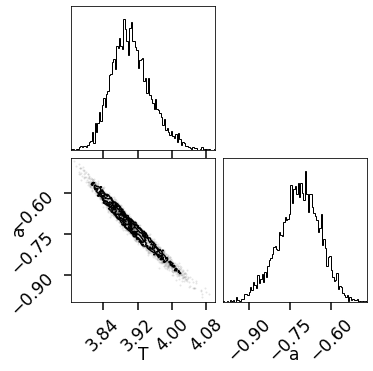

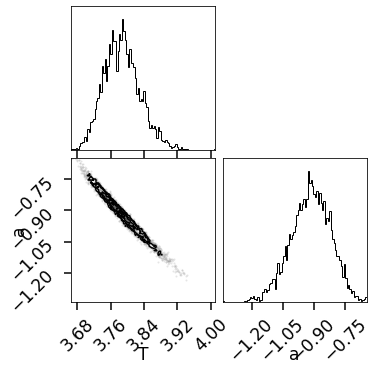

In [55]:

plot_corner_emcee(samplesflat_total)

In [56]:
10**np.asarray(display_median_from_chain(samplesflat_total)) 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

/home/aaronmaas/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


array([[7980.653190688497, 6094.8760432208055],
       [array([1.10164486, 1.11974609]), array([1.10230145, 1.10980513])],
       [0.19258494546271354, 0.12205640139266803],
       [array([1.20161863, 1.18247621]), array([1.2542018 , 1.23822365])]],
      dtype=object)

In [57]:
np.save("../data/MCMC/logsamples_0.5xbrightness_total", samples_total, allow_pickle=True, fix_imports=True)
np.save("../data/MCMC/logsamplesflat_0.5xbrighntess_total", samplesflat_total, allow_pickle=True, fix_imports=True)

In [42]:
samples_total= np.load("../data/MCMC/logsamples_0.5xbrightness_total.npy", allow_pickle=True, fix_imports=True)
samplesflat_total= np.load("../data/MCMC/logsamplesflat_0.5xbrighntess_total.npy", allow_pickle=True, fix_imports=True)

/home/aaronmaas/Desktop/Flares_Trappist/notebooks/funcs/blackbody_model.py:6: RuntimeWarning: overflow encountered in exp
  flare_contribution = (a*R_star)**2/(np.exp((c.h * c.c)/(T_flare*c.k*wavelength)) -1)
/home/aaronmaas/Desktop/Flares_Trappist/notebooks/funcs/blackbody_model.py:6: RuntimeWarning: overflow encountered in exp
  flare_contribution = (a*R_star)**2/(np.exp((c.h * c.c)/(T_flare*c.k*wavelength)) -1)
/home/aaronmaas/Desktop/Flares_Trappist/notebooks/funcs/blackbody_model.py:6: RuntimeWarning: overflow encountered in exp
  flare_contribution = (a*R_star)**2/(np.exp((c.h * c.c)/(T_flare*c.k*wavelength)) -1)


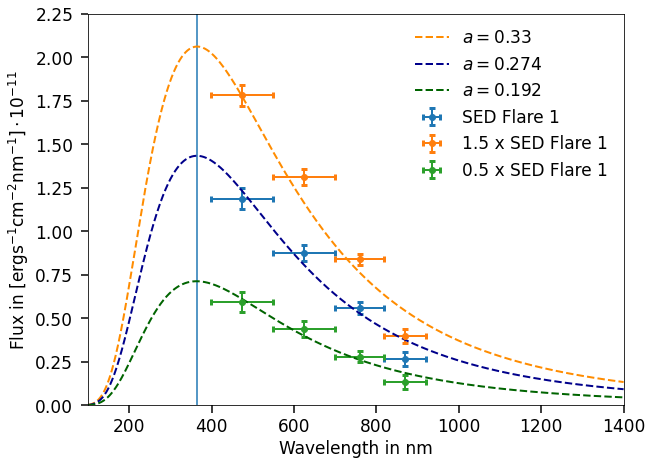

In [62]:
#need to change units at the moment W/m^2


lc = [4.745e-07, 6.245e-07, 7.6e-07, 8.695000000000001e-07]
ranges = np.asarray([1.4999999999999994e-07, 1.5000000000000005e-07, 1.1900000000000005e-07, 1e-07])/2*1e9
#sum of datapoints in wavelength array for continous model
limitss = np.asarray([limit[0][1] - limit[0][0], limit[1][1] - limit[1][0] , limit[2][1] - limit[2][0], \
                      limit[3][1] - limit[3][0]]) 

import matplotlib.pyplot as plt
from matplotlib import rcParams  #ticks for axes
rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams["figure.figsize"] = [9.6, 7.2] 
rcParams.update({'font.size': 17})

#plt.figure(figsize=(12,9.6))
plt.rcParams['font.size'] = '17'


plt.errorbar(np.asarray(wavelength_M2)*1e9,1e6*brightness_flares[0]/limitss, xerr = ranges, yerr = 1e6*brightnesserror_flares[0]/limitss ,fmt=".", color = "tab:blue", \
                        ls = 'None', marker = 'o', linewidth = 2 , capsize=3, capthick=3,  label = "SED Flare 1")

plt.errorbar(np.asarray(wavelength_M2)*1e9,1e6*brightness_flares[0]*1.5/limitss, xerr = ranges, yerr = 1e6*brightnesserror_flares[0]/limitss ,fmt=".", color = "tab:orange", \
                        ls = 'None', marker = 'o', linewidth = 2 , capsize=3, capthick=3,  label = "1.5 x SED Flare 1")

plt.errorbar(np.asarray(wavelength_M2)*1e9,1e6*brightness_flares[0]*0.5/limitss, xerr = ranges, yerr = 1e6*brightnesserror_flares[0]/limitss ,fmt=".", color = "tab:green", \
                        ls = 'None', marker = 'o', linewidth = 2 , capsize=3, capthick=3,  label = "0.5 x SED Flare 1")


#plt.plot(wavelength_SED*1e9,  \
#         1e17*brightness_mod_continous(wavelength_SED, 7950, 0.5e-6, trappist_SED[:,1], t_star, R_star = r_star, dist_star = dist_star, model = None), ls = "dashed",\
#         label = r"$T_\mathrm{eff}$ = $7950^{+430}_{-380}$ K", linewidth = 2, color = "darkblue") #, array([5127.88550742 
plt.plot(wavelength_SED*1e9,  \
         1e6*brightness_mod_continous(wavelength_SED, 7936, 0.33, trappist_SED[:,1], t_star, R_star = r_star, dist_star = dist_star, model = None), ls = "dashed",\
         label = r"$a = 0.33$  ", linewidth = 2, color = "darkorange") #, array([5127.88550742 
plt.plot(wavelength_SED*1e9,  \
         1e6*brightness_mod_continous(wavelength_SED, 7950, 0.274, trappist_SED[:,1], t_star, R_star = r_star, dist_star = dist_star, model = None), ls = "dashed",\
         label = r"$a = 0.274$ ", linewidth = 2, color = "darkblue") #, array([5127.88550742 

plt.plot(wavelength_SED*1e9,  \
         1e6*brightness_mod_continous(wavelength_SED, 7970, 0.192, trappist_SED[:,1], t_star, R_star = r_star, dist_star = dist_star, model = None), ls = "dashed",\
         label = r"$a = 0.192$ ", linewidth = 2, color = "darkgreen") #, array([5127.88550742 
        
plt.xlabel("Wavelength in nm")
plt.ylabel(r"Flux in $[\mathrm{erg} \mathrm{s}^{-1} \mathrm{cm}^{-2} \mathrm{nm}^{-1}] \cdot 10^{-6}$")

plt.vlines(364, ymin = 0, ymax=2.25)

plt.xlim(100,1400)

plt.xlabel("Wavelength in nm")
plt.ylabel(r"Flux in $[\mathrm{erg} \mathrm{s}^{-1} \mathrm{cm}^{-2} \mathrm{nm}^{-1}] \cdot 10^{-11}$") #W/^3 --> erg/cm^2/s^1/nm
plt.ylim(0,2.25)

plt.legend(loc = "upper right",frameon = False) 